In [1]:
from google.colab import drive
drive.mount('/content/drive')
folder = 'drive/MyDrive/Code/GitHub/CellularAutomata'
import sys
sys.path.insert(1, folder)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import ca_model_emotions as ca_model
import emotions_dataset as eds
import visualisation_emotions as vis_ca
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from IPython.display import clear_output
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 3433588537933107662
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 14638920512
locality {
  bus_id: 1
  links {
  }
}
incarnation: 7171630125661366439
physical_device_desc: "device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5"
]


In [3]:
# import importlib
# importlib.reload(ca_model)
# importlib.reload(vis_ca)

In [4]:
# Type of Run
JustTestingCodeQ = True # If True run everything faster, for Debugging
LoadPreviousModelQ = False # if True we load the model, either for further training or just testing
i_step_load = 1000
RunTrainingQ = True # If True we run the neural network training
RunTestMoviesQ = True # if True, in the end we test an increasing size of inputs
MutateTestingQ = True # if True, during testing we mutate the image
SEED_TRAINING = 1
SEED_MOVIES = 1

In [5]:
# Model Options
model_complexity = 'middle' # 'simplest' 'middle' 'complex'
NO_NEIGHBORS = 3 # the number of immediate neighbors to consider # 1 2 3 4
AddNoiseQ = True # if True then the normal update of the CA has noise added
InitializeRandomQ = True # if True, the initial state of the CA is random
MutateTrainingQ = True # if True, during training we mutate the image to anothe random one
no_channels = '4TimesClasses' # 'SameClasses' '5PlusClasses' '4TimesClasses'
TR_EVOLVE = 50 # Number of time steps to let CA evolve for each input during training
TST_EVOLVE = 50 # Number of time steps to let CA evolve for each input during testing
BATCH_SIZE = 64 # number of images per batch
LR = 1e-3 # initial learning rate
UseLRScheduleQ = True # if True use Adam with a learning rate schedule

In [6]:
# Task and Dataset
RebuildDatasetQ = False # if True we rebuild the dataset
target_classes = ['Happy', 'Sad'] # ['Happy', 'Neutral', 'Sad', 'Fear', 'Angry', 'Surprise', 'Disgust']
H, W = 48, 48
SEED_DATASET = 1
DataAugmentationQ = True
DataBalancingQ = True

In [7]:
if JustTestingCodeQ:
    TR_NO_ITERATIONS = 500 # number of iterations for the training loop
    EXPORT_EVERY = 100 # number of iterations between each model export
    VISUALISE_EVERY = 50 # number of iteration between each model visualisation
    i_step_verify = [500] # [250, 500]
else:
    TR_NO_ITERATIONS = 500000 # number of iterations for the training loop
    EXPORT_EVERY = 2000 # number of iterations between each model export
    VISUALISE_EVERY = 500 # number of iteration between each model visualisation
    i_step_verify = [240000, 500000] # [240000, 500000]

    TR_NO_ITERATIONS = 5000 # number of iterations for the training loop
    EXPORT_EVERY = 1000 # number of iterations between each model export
    VISUALISE_EVERY = 500 # number of iteration between each model visualisation
    i_step_verify = [0, 5000] # [240000, 500000]

    TR_NO_ITERATIONS = 20000 # number of iterations for the training loop
    EXPORT_EVERY = 1000 # number of iterations between each model export
    VISUALISE_EVERY = 500 # number of iteration between each model visualisation
    i_step_verify = [0, 20000] # [240000, 500000]

    # TR_NO_ITERATIONS = 50000 # number of iterations for the training loop
    # EXPORT_EVERY = 2000 # number of iterations between each model export
    # VISUALISE_EVERY = 500 # number of iteration between each model visualisation
    # i_step_verify = [50000, 100000] # [240000, 500000]

    # TR_NO_ITERATIONS = 200000 # number of iterations for the training loop
    # EXPORT_EVERY = 2000 # number of iterations between each model export
    # VISUALISE_EVERY = 500 # number of iteration between each model visualisation
    # i_step_verify = [100000, 200000] # [240000, 500000]
    
    #
if LoadPreviousModelQ and not RunTrainingQ:
    i_step_verify = [i_step_load]

tc_str = str(target_classes).replace('[', '').replace(']', '').replace(', ', '_').replace('\'', '')
ds_str = 'Emotions_' + tc_str + '_Bal{}_Aug{}_Seed{}'.format(DataBalancingQ, DataAugmentationQ, SEED_DATASET)
print(ds_str)
id_str = 'CA_{}_ModlComplx{}_AddNoise{}_InitRnd{}_MutTrain{}_Channels{}'.format(ds_str, model_complexity, AddNoiseQ, InitializeRandomQ, MutateTrainingQ, no_channels) # the prefix to all file names which will be use for saving and loading the model
print(id_str)

NO_CLASSES = len(target_classes) # Number of classes that the CA must distinguish

if NO_CLASSES == 1:
    color_lookup = tf.constant([
                        [255, 0, 0], #These are the colors for the different classes
                        [0, 0, 0], # This is for when no class is voted.
                        ])
elif NO_CLASSES == 2:
    color_lookup = tf.constant([
                        [255, 0, 0], #These are the colors for the different classes
                        [0, 255, 0],
                        [0, 0, 0], # This is for when no class is voted.
                        ])
elif NO_CLASSES == 3:
    color_lookup = tf.constant([
                        [255, 0, 0], #These are the colors for the different classes
                        [0, 255, 0],
                        [0, 0, 255],
                        [0, 0, 0], # This is for when no class is voted.
                        ])
elif NO_CLASSES == 5:
    color_lookup = tf.constant([
                        [255, 0, 0], #These are the colors for the different classes
                        [0, 255, 0],
                        [0, 0, 255],
                        [255, 255, 0],
                        [0, 255, 255],
                        [0, 0, 0], # This is for when no class is voted.
                        ])
elif NO_CLASSES == 8:
    color_lookup = tf.constant([
                        [85, 85, 85], #These are the colors for the different classes
                        [255, 0, 0], 
                        [0, 255, 0],
                        [0, 0, 255],
                        [255, 255, 0],
                        [0, 255, 255],
                        [255, 0, 255],
                        [170, 170, 170],
                        [0, 0, 0], # This is for when no class is voted.
                        ])

if no_channels == 'SameClasses':
    NO_CHANNELS = NO_CLASSES # number of hidden states of the CA, must be at least NO_CLASSES because there are two outputs
elif no_channels == '4TimesClasses':
    NO_CHANNELS = 4 * NO_CLASSES # number of hidden states of the CA, must be at least NO_CLASSES because there are two outputs
elif no_channels == '5PlusClasses':
    NO_CHANNELS = 5 + NO_CLASSES # number of hidden states of the CA, must be at least NO_CLASSES because there are two outputs

if UseLRScheduleQ:
    first_point = int(TR_NO_ITERATIONS*0.3333)
    second_point = int(TR_NO_ITERATIONS*0.6667)
    if LoadPreviousModelQ and RunTrainingQ:
        if i_step_load > second_point:
            trainer = tf.keras.optimizers.Adam(learning_rate=LR*0.01) # use ADAM optimizer
        elif i_step_load > first_point:
            remaining_steps = TR_NO_ITERATIONS - i_step_load
            lr_sched = tf.keras.optimizers.schedules.PiecewiseConstantDecay([2 * (second_point - i_step_load)], [LR*0.1, LR*0.01]) # we need to multiply by two because in each training step we perform 2 gradient descents
            trainer = tf.keras.optimizers.Adam(lr_sched) # use ADAM optimizer with learning rate schedule
        else:
            lr_sched = tf.keras.optimizers.schedules.PiecewiseConstantDecay([2 * (first_point - i_step_load), 2 * (second_point - i_step_load)], [LR, LR*0.1, LR*0.01]) # we need to multiply by two because in each training step we perform 2 gradient descents
    else:
        lr_sched = tf.keras.optimizers.schedules.PiecewiseConstantDecay([2*first_point, 2*second_point], [LR, LR*0.1, LR*0.01]) # we need to multiply by two because in each training step we perform 2 gradient descents
    trainer = tf.keras.optimizers.Adam(lr_sched) # use ADAM optimizer with learning rate schedule
else:
    trainer = tf.keras.optimizers.Adam(learning_rate=LR) # use ADAM optimizer

loss_log = np.zeros(TR_NO_ITERATIONS) # for plotting of loss function across time
loss_log_classes = np.zeros((TR_NO_ITERATIONS, NO_CLASSES)) # for plotting of loss function across time

Emotions_Happy_Sad_BalTrue_AugTrue_Seed1
CA_Emotions_Happy_Sad_BalTrue_AugTrue_Seed1_ModlComplxmiddle_AddNoiseTrue_InitRndTrue_MutTrainTrue_Channels4TimesClasses


In [8]:
# Prepare the dataset
BuildDS = False
if RebuildDatasetQ:
    BuildDS = True
else:
    try:
        res = np.load(folder + '/dataset/{}.npz'.format(ds_str))
        x_train, x_test, y_train, y_test = res['x_train'], res['x_test'], res['y_train'], res['y_test']
    except:
        BuildDS = True
if BuildDS:

    x_train, x_test, y_train, y_test = eds.build_dataset(folder, target_classes, H, W, SEED_DATASET, ds_str, DataBalancingQ, DataAugmentationQ)
    np.savez(folder + '/dataset/{}.npz'.format(ds_str), x_train=x_train, x_test=x_test, y_train=y_train, y_test=y_test)

    cols=7
    rows=7
    fig, ax = plt.subplots()
    DISP = np.zeros((1, cols * W + 1))
    RES = [[0 for i in range(cols)] for j in range(rows)]
    for i in range(rows):
        disp = np.zeros((H, 1))
        for j in range(cols):
            image_idx = np.random.randint(x_train.shape[0])
            disp = np.hstack((disp, x_train[image_idx, :, :]))
            RES[i][j] = y_train[image_idx]
        DISP = np.vstack((DISP, disp))
    ax.imshow(DISP)
    print(np.array(RES))

y_train_hot = eds.to_classes_dim_label(x_train, y_train, NO_CLASSES)

In [9]:
print(y_train_hot.shape, y_train.shape, np.all(np.sum(y_train_hot, axis=(1, 2, 3)) == 48 ** 2), np.max(y_train_hot), np.min(y_train_hot))

(69264, 48, 48, 2) (69264,) True 1.0 0.0


In [10]:
y = 1
for i in range(y_train.shape[0]):
    y *= np.sum(y_train_hot[i, 0, 0, y_train[i]])
print(y)

1.0


In [11]:
np.isnan(x_train).any()

False

In [12]:
if LoadPreviousModelQ:
    ca, loss_log, loss_log_classes = ca_model.get_model(folder, id_str, i_step_load, NO_NEIGHBORS, NO_CHANNELS, NO_CLASSES, H, W, AddNoiseQ, model_complexity)
    ITER = i_step_load + 1
else:
    ca = ca_model.CAModel(NO_NEIGHBORS, NO_CHANNELS, NO_CLASSES, H, W, add_noise=AddNoiseQ, model_complexity=model_complexity)
    ITER = 0

In [13]:
ca.update_state.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (1, 48, 48, 40)           17680     
_________________________________________________________________
conv2d_1 (Conv2D)            (1, 48, 48, 8)            328       
Total params: 18,008
Trainable params: 18,008
Non-trainable params: 0
_________________________________________________________________


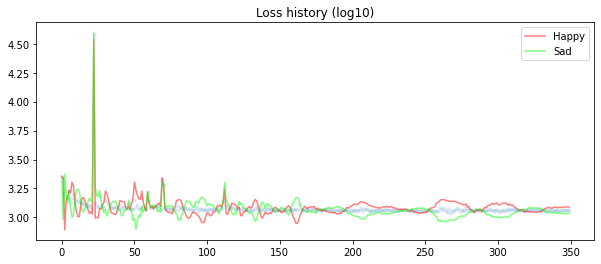

 step: 353, log10(loss): 3.0617458820343018, log10(loss)[classes]: [3.0829623 3.0394394]

In [ ]:
# Training happens here
np.random.seed(SEED_TRAINING)
if RunTrainingQ:
    # Training Loop
    for i in range(ITER, TR_NO_ITERATIONS):
        b_idx = np.random.randint(x_train.shape[0], size=BATCH_SIZE)
        if InitializeRandomQ:
            x0 = ca.initialize_random(x_train[b_idx])
        else:
            x0 = ca.initialize(x_train[b_idx])
        y0 = y_train_hot[b_idx]
        y0_label = y_train[b_idx]
        y0_label = tf.convert_to_tensor(y0_label)        

        x, loss, c_l = ca_model.train_step(trainer, ca, x0, y0, y0_label, TR_EVOLVE, NO_CLASSES, MutateTrainingQ=MutateTrainingQ)

        loss_log[i] = loss.numpy()
        loss_log_classes[i, :] = [k.numpy() for k in c_l]

        if i % VISUALISE_EVERY == 0:
            clear_output()
            vis_ca.plot_loss(loss_log[:i], loss_log_classes[:i, :], folder, id_str, target_classes, color_lookup, True)
        if i % EXPORT_EVERY == 0:
            ca_model.export_model(folder, id_str, ca, i, loss_log, loss_log_classes)

        if NO_CLASSES > 5:
            print('\r step: {}, log10(loss): {}'.format(i + 1, np.log10(loss)), end='')
        else:
            print('\r step: {}, log10(loss): {}, log10(loss)[classes]: {}'.format(i + 1, np.log10(loss), np.log10(c_l)), end='')
    ca_model.export_model(folder, id_str, ca, TR_NO_ITERATIONS, loss_log, loss_log_classes)

In [ ]:
if RunTestMoviesQ:
    eval_bs = 5 ** 2 # number of samples to show in the movie
    for i_step_v in i_step_verify:
        ca, loss_log, loss_log_classes = ca_model.get_model(folder, id_str, i_step_v, NO_NEIGHBORS, NO_CHANNELS, NO_CLASSES, H, W, AddNoiseQ, model_complexity)

        np.random.seed(SEED_MOVIES)

        new_idx = np.random.randint(0, x_test.shape[0] - 1, size=eval_bs)
        if InitializeRandomQ:
            x0 = ca.initialize_random(x_test[new_idx])
        else:
            x0 = ca.initialize(x_test[new_idx])

        vis_ca.make_run_videos(folder, id_str, i_step_v, TST_EVOLVE, MutateTestingQ, x0, ca, color_lookup)